# 3. Multi-Head Attention

**Running parallel attention heads to capture different relationships**

## Why Multiple Heads?

A single attention head can only focus on one type of relationship at a time. **Multi-head attention** runs multiple attention operations in parallel, each learning to focus on different aspects:

- One head might focus on **syntactic relationships** (subject-verb agreement)
- Another on **semantic relationships** (related concepts)
- Another on **positional patterns** (nearby words)

It's like having multiple experts examining the same data from different perspectives.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism."""
    
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        
        # Linear projections for Q, K, V, and output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        """
        Args:
            x: (batch, seq_len, d_model)
            mask: optional causal mask
        
        Returns:
            output: (batch, seq_len, d_model)
            attention_weights: (batch, num_heads, seq_len, seq_len)
        """
        batch_size, seq_len, _ = x.shape
        
        # Project to Q, K, V
        Q = self.W_q(x)  # (batch, seq_len, d_model)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Reshape to (batch, num_heads, seq_len, d_k)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 1, float('-inf'))
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        context = torch.matmul(attention_weights, V)
        
        # Reshape back: (batch, seq_len, d_model)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        # Final projection
        output = self.W_o(context)
        
        return output, attention_weights

In [2]:
# Example
d_model = 64
num_heads = 4
batch_size = 2
seq_len = 8

mha = MultiHeadAttention(d_model, num_heads)

# Random input
x = torch.randn(batch_size, seq_len, d_model)

# Create causal mask
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)

output, attn_weights = mha(x, mask=mask)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"  (batch, num_heads, seq_len, seq_len)")

Input shape: torch.Size([2, 8, 64])
Output shape: torch.Size([2, 8, 64])
Attention weights shape: torch.Size([2, 4, 8, 8])
  (batch, num_heads, seq_len, seq_len)


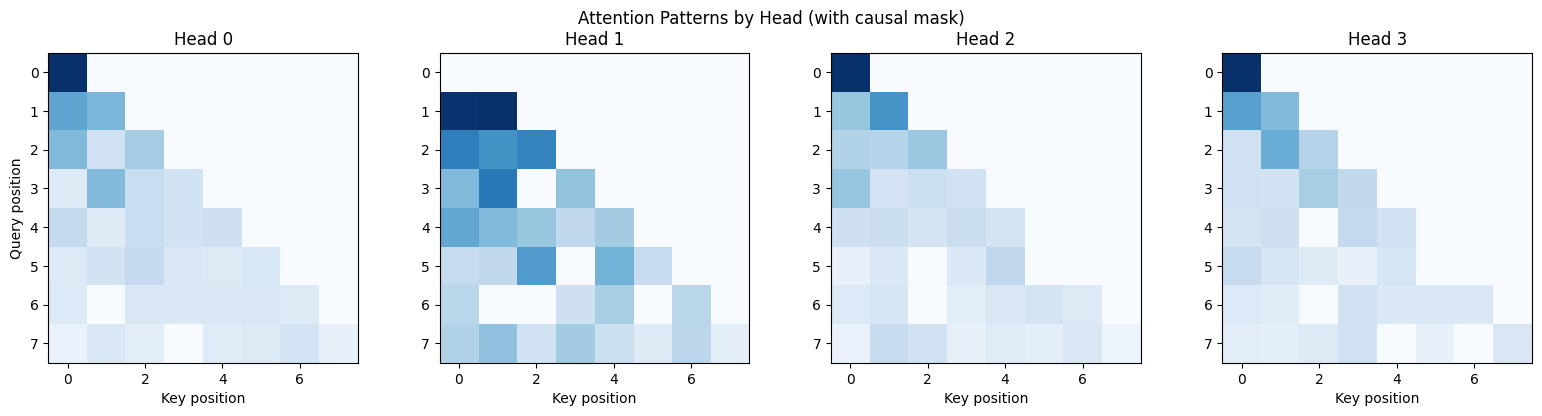

In [3]:
# Visualize attention patterns for different heads
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for head_idx in range(num_heads):
    ax = axes[head_idx]
    weights = attn_weights[0, head_idx].detach().numpy()
    im = ax.imshow(weights, cmap='Blues')
    ax.set_title(f'Head {head_idx}')
    ax.set_xlabel('Key position')
    if head_idx == 0:
        ax.set_ylabel('Query position')

plt.suptitle('Attention Patterns by Head (with causal mask)')
plt.tight_layout()
plt.show()

## How Multi-Head Attention Works

```
Input x: (batch, seq_len, d_model)
    │
    ├─→ W_q → Q ─┐
    ├─→ W_k → K ─┼─→ Split into num_heads
    └─→ W_v → V ─┘       │
                         ├─→ Head 0: Attention(Q₀, K₀, V₀)
                         ├─→ Head 1: Attention(Q₁, K₁, V₁)
                         ├─→ ...
                         └─→ Head n: Attention(Qₙ, Kₙ, Vₙ)
                                     │
                         Concatenate all head outputs
                                     │
                                 W_o → Output
```

In [4]:
# Count parameters
total_params = sum(p.numel() for p in mha.parameters())
print(f"Multi-Head Attention Parameters:")
print(f"  W_q: {d_model} × {d_model} = {d_model * d_model}")
print(f"  W_k: {d_model} × {d_model} = {d_model * d_model}")
print(f"  W_v: {d_model} × {d_model} = {d_model * d_model}")
print(f"  W_o: {d_model} × {d_model} = {d_model * d_model}")
print(f"  + biases")
print(f"  Total: {total_params:,} parameters")

Multi-Head Attention Parameters:
  W_q: 64 × 64 = 4096
  W_k: 64 × 64 = 4096
  W_v: 64 × 64 = 4096
  W_o: 64 × 64 = 4096
  + biases
  Total: 16,640 parameters


## Next: Feed-Forward Networks

After attention, each position goes through a position-wise feed-forward network that adds non-linearity and increases the model's capacity.